In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import librosa.display
import numpy as np
import datetime
import time
import os
import json
from skimage.transform import resize

from src.data import NSynthDataset
from src.utils import print_and_log
from src.models import WavAutoencoder

In [7]:
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
else:  
    device = torch.device("cpu") 

In [8]:
hparams = {
    'checkpoint' : None,
    'feature_type' : 'raw',
    'instrument_source' : [0],
    'scaling' : 'normalize',
    'mu_law_companding' : True,
    'resize' : (65536,),
    'n_epochs' : 25,
    'batch_size' : 64,
    'lr' : 0.001,
    'hidden_dim' : 1024,
    'display_iters' : 100,
    'val_iters' : 1000,
    'n_val_samples' : 1000,
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [9]:
train_dataset = NSynthDataset(
    'data/nsynth/nsynth-train', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling'],
    resize=hparams['resize'],
    mu_law_companding=hparams['mu_law_companding']
)

val_dataset = NSynthDataset(
    'data/nsynth/nsynth-valid', 
    instrument_source=hparams['instrument_source'], 
    feature_type=hparams['feature_type'],
    scaling=hparams['scaling'],
    resize=hparams['resize'],
    mu_law_companding=hparams['mu_law_companding']
)

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [12]:
model = WavAutoencoder(h_dim=hparams['hidden_dim']).to(device)
print('# of parameters : {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# of parameters : 28410753


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [14]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/autoencoder/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()
print_and_log('{}'.format(model.__class__.__name__), log_file)

for k, v in hparams.items(): print_and_log('{} : {}'.format(k, v), log_file)

WavAutoencoder


[0,     1] loss : 1.4531
[0,   100] loss : 0.6932
[0,   200] loss : 0.6935
[0,   300] loss : 0.6935
[0,   400] loss : 0.6935
[0,   500] loss : 0.6934
[0,   600] loss : 0.6932
[0,   700] loss : 0.6934
[0,   800] loss : 0.6933
[0,   900] loss : 0.6933
[0,  1000] loss : 0.6928
Val - loss : 0.6943


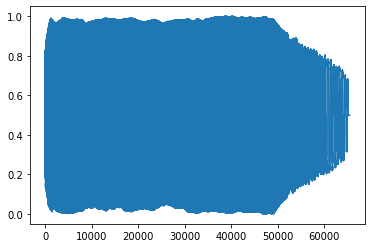

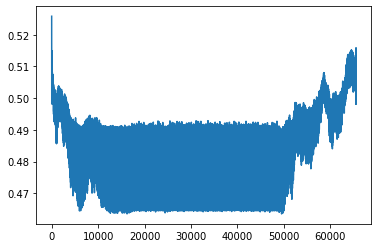

Weights saved in train_results/autoencoder/20200604-223822/model-1000.weights
[0,  1100] loss : 0.6930
[0,  1200] loss : 0.6904
[0,  1300] loss : 0.6915


KeyboardInterrupt: 

In [15]:
loss_fn = nn.BCELoss(reduction='none')
loss_weighting = lambda x : 1 #99*(x**2)+1

ckpt_weights_path = None
best_loss = 1e10
since_best = 0
done = False

if hparams['checkpoint']:
    print_and_log('Resuming training from {}'.format(hparams['checkpoint']), log_file)
    ckpt = torch.load(hparams['checkpoint'])
    epoch = ckpt['epoch']
    itr = ckpt['itr']
    optimizer.load_state_dict(ckpt['optimizer'])
    model.load_state_dict(ckpt['model'])
    best_loss = ckpt['best_loss']
else:
    epoch = 0
    itr = 0

for epoch in range(epoch, hparams['n_epochs']):
    if done:
        break
    
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        batch = batch.unsqueeze(1).to(device)
        outputs = model(batch)
        
        loss = loss_fn(outputs, batch)
        loss = (loss_weighting(batch)*loss).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            print_and_log('[{}, {:5d}] loss : {:.4f}'.format(epoch, itr, loss.item()), log_file)
            
        if itr % hparams['val_iters'] == 0:
            model.eval()
            
            with torch.no_grad():
                ct, i, val_loss = 0, 0, 0.0
                for batch in val_dataloader:
                    i += 1
                    ct += batch.size(0)
                    batch = batch.unsqueeze(1).to(device)
                    outputs = model(batch)

                    loss = loss_fn(outputs, batch)
                    loss = (loss_weighting(batch)*loss).mean()
                    val_loss += (loss.item() - val_loss)/i

                    if ct >= hparams['n_val_samples']:
                        break
            
            print_and_log('Val - loss : {:.4f}'.format(val_loss), log_file)
            plt.plot(batch[0][0].cpu().numpy())
            plt.show()
            plt.plot(outputs[0][0].detach().cpu().numpy())
            plt.show()
            
            if val_loss < best_loss:
                since_best = 0
                best_loss = val_loss
                
                # save weights
                if ckpt_weights_path:
                    os.remove(ckpt_weights_path)
                ckpt_weights_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
                torch.save(model.state_dict(), ckpt_weights_path)
                print_and_log('Weights saved in {}'.format(ckpt_weights_path), log_file)
                
                # save meta information
                ckpt_meta_path = os.path.join(results_dir, 'checkpoint')
                torch.save({
                    'best_loss' : best_loss,
                    'epoch' : epoch,
                    'itr' : itr,
                    'optimizer' : optimizer.state_dict(),
                    'model' : model.state_dict()
                }, ckpt_meta_path)
            else:
                since_best += 1
                if since_best >= hparams['n_early_stopping']:
                    done = True
                    print_and_log('Early stopping... training complete', log_file)
                    
            model.train()